In [22]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from xgboost import XGBClassifier
import category_encoders as ce
from sklearn import model_selection
from sklearn.metrics import accuracy_score

In [23]:

%matplotlib inline

In [24]:
train_data=pd.read_csv(r'C:\Users\Smegn\Documents\GitHub\Pharmaceutical-Sales-prediction-across-multiple-stores\data\train.csv')

C:\Users\Smegn\anaconda3\newanaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [25]:
train_data.head(3)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1


In [26]:
test_data=pd.read_csv(r'C:\Users\Smegn\Documents\GitHub\Pharmaceutical-Sales-prediction-across-multiple-stores\data\test.csv')

In [27]:
test_data.head(3)

,Id,Store,DayOfWeek,Date,Open,Promo,StateHoliday,SchoolHoliday
0,1,1,4,2015-09-17,1.0,1,0,0
1,2,3,4,2015-09-17,1.0,1,0,0
2,3,7,4,2015-09-17,1.0,1,0,0


In [14]:
store_data=pd.read_csv(r'C:\Users\Smegn\Documents\GitHub\Pharmaceutical-Sales-prediction-across-multiple-stores\data\store.csv')

In [16]:
store_data.head(3)

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


# 1. Data Preprocessing

In [31]:
train_data.info()
#it doesn't contain null value

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


In [29]:
#open column has one missing value
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             41088 non-null  int64  
 1   Store          41088 non-null  int64  
 2   DayOfWeek      41088 non-null  int64  
 3   Date           41088 non-null  object 
 4   Open           41077 non-null  float64
 5   Promo          41088 non-null  int64  
 6   StateHoliday   41088 non-null  object 
 7   SchoolHoliday  41088 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 2.5+ MB


In [36]:
#Columns: CompetitionDistance, CompetitionOpenSinceMonth ,CompetitionOpenSinceYear, Promo2SinceWeek,Promo2SinceYear, PromoInterval 
#has missing values
store_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


In [39]:
store_data.isna().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

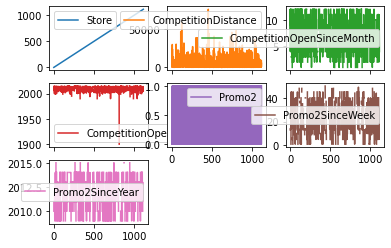

In [70]:
store_data.plot(subplots=True, layout=(3,3))

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

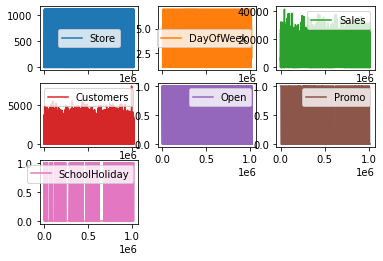

In [69]:
train_data.plot(subplots=True, layout=(3,3))

array([[<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
       [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

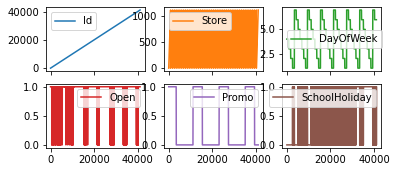

In [68]:
test_data.plot(subplots=True, layout=(3,3))

In [108]:
 #Function to calculate missing values by column
def missing_values_table(df):
    # Total missing values
    mis_val = df.isnull().sum()

    # Percentage of missing values
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # dtype of missing values
    mis_val_dtype = df.dtypes

    # Make a table with the results
    mis_val_table = pd.concat([mis_val, mis_val_percent, mis_val_dtype], axis=1)

    # Rename the columns
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values', 2: 'Dtype'})

    # Sort the table by percentage of missing descending
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)

    # Print some summary information
    print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
        "There are " + str(mis_val_table_ren_columns.shape[0]) +
          " columns that have missing values.")

    # Return the dataframe with missing information
    return mis_val_table_ren_columns

In [109]:
missing_values_table(train_data)

Your selected dataframe has 9 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values,Dtype


In [110]:
missing_values_table(test_data)

Your selected dataframe has 8 columns.
There are 1 columns that have missing values.


,Missing Values,% of Total Values,Dtype
Open,11,0.0,float64


In [111]:
missing_values_table(store_data)

Your selected dataframe has 10 columns.
There are 6 columns that have missing values.


,Missing Values,% of Total Values,Dtype
Promo2SinceWeek,544,48.8,float64
Promo2SinceYear,544,48.8,float64
PromoInterval,544,48.8,object
CompetitionOpenSinceMonth,354,31.7,float64
CompetitionOpenSinceYear,354,31.7,float64
CompetitionDistance,3,0.3,float64


In [115]:
def plot_count(df:pd.DataFrame, column:str) -> None:
    plt.figure(figsize=(12, 7))
    sb.countplot(data=df, x=column)
    plt.title(f'Distribution of {column}', size=20, fontweight='bold')
    plt.show()

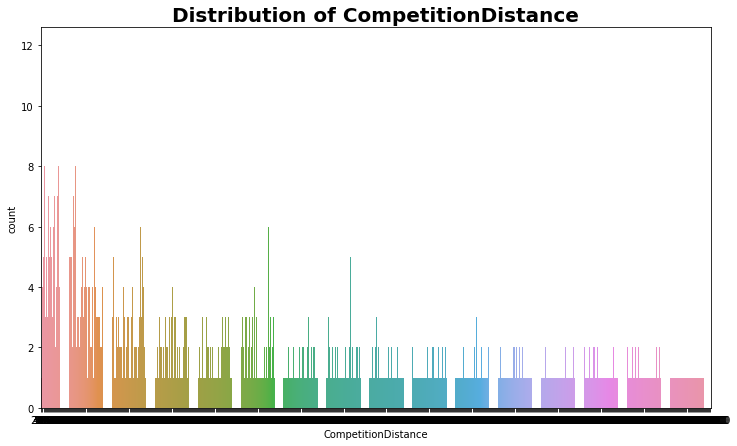

In [116]:
#before we fill missing value , lets first see distribution of each data
plot_count(store_data, "CompetitionDistance")

In [ ]:
plot_count(store_data, "CompetitionDistance")

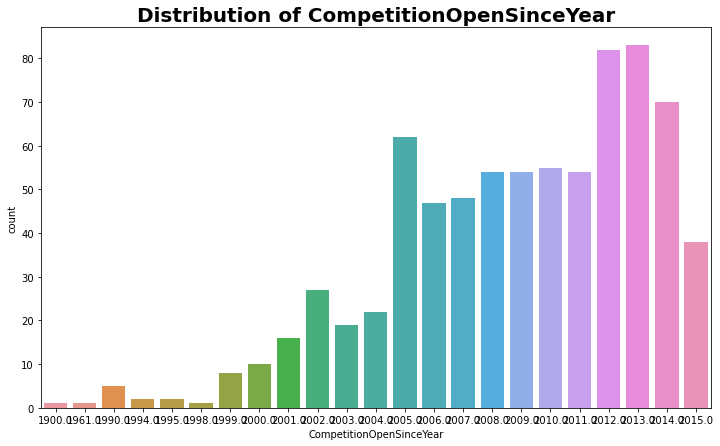

In [117]:
plot_count(store_data, "CompetitionOpenSinceYear")

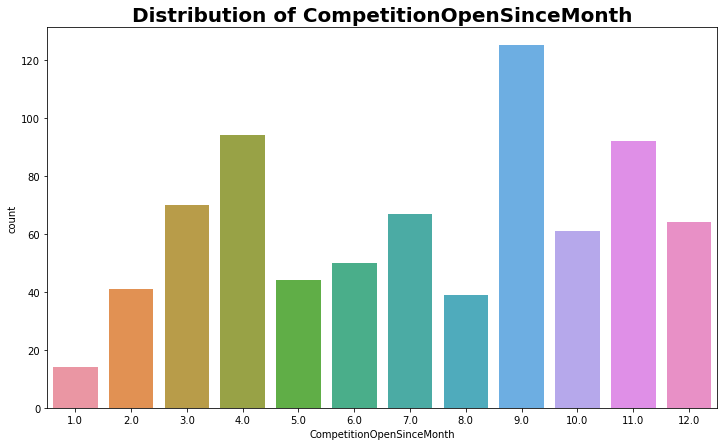

In [118]:
plot_count(store_data, "CompetitionOpenSinceMonth")

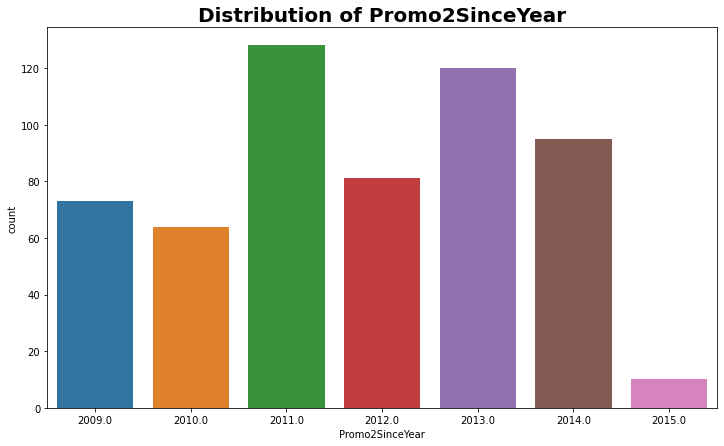

In [119]:
plot_count(store_data, "Promo2SinceYear")

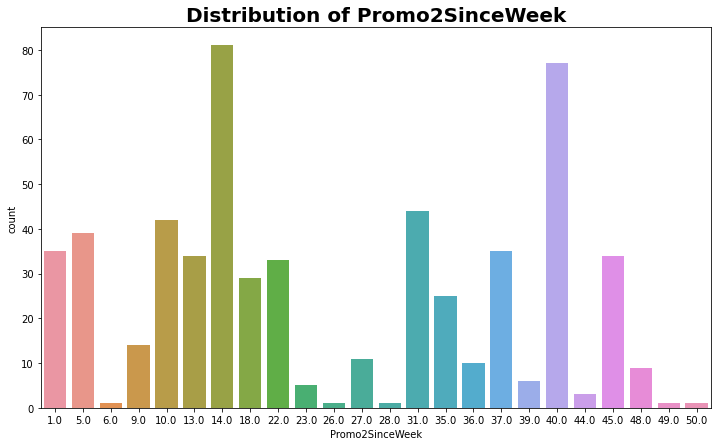

In [120]:
plot_count(store_data, "Promo2SinceWeek")

In [103]:
def fix_outlier(df, column):
    df[column] = np.where(df[column] > df[column].quantile(0.95), df[column].median(),df[column])
    
    return df[column]

def plot_hist(df:pd.DataFrame, column:str, color:str)->None:
    # plt.figure(figsize=(15, 10))
    # fig, ax = plt.subplots(1, figsize=(12, 7))
    sns.displot(data=df, x=column, color=color, kde=True, height=7, aspect=2)
    plt.title(f'Distribution of {column}', size=20, fontweight='bold')
    plt.show()

In [128]:
def plot_box(df:pd.DataFrame, x_col:str, title:str) -> None:
    plt.figure(figsize=(12, 7))
    sb.boxplot(data = df, x=x_col)
    plt.title(title, size=20)
    plt.xticks(rotation=75, fontsize=14)
    plt.show()

def plot_box_multi(df:pd.DataFrame, x_col:str, y_col:str, title:str) -> None:
    plt.figure(figsize=(12, 7))
    sb.boxplot(data = df, x=x_col, y=y_col)
    plt.title(title, size=20)
    plt.xticks(rotation=75, fontsize=14)
    plt.yticks( fontsize=14)
    plt.show()

def plot_scatter(df: pd.DataFrame, x_col: str, y_col: str, title: str, hue: str, style: str) -> None:
    plt.figure(figsize=(12, 7))
    sb.scatterplot(data = df, x=x_col, y=y_col, hue=hue, style=style)
    plt.title(title, size=20)
    plt.xticks(fontsize=14)
    plt.yticks( fontsize=14)
    plt.show()

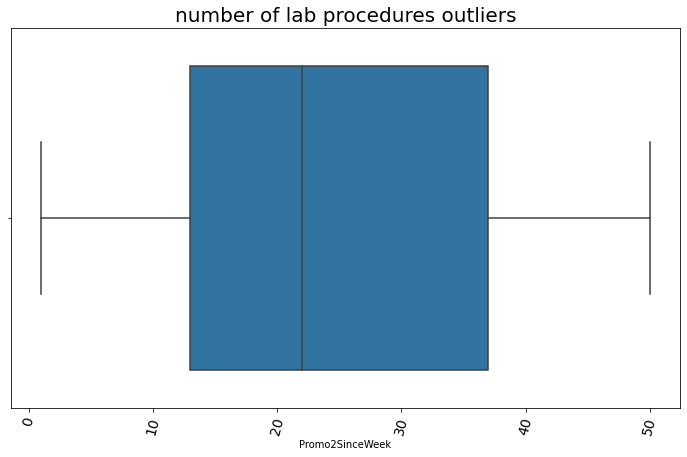

In [129]:
plot_box(store_data, "Promo2SinceWeek", "number of lab procedures outliers")

In [106]:
plot_hist(store_data:pd.DataFrame, column:PromoInterval, color:red)

SyntaxError: invalid syntax (<ipython-input-106-9a08da8a6515>, line 1)

In [102]:
missing_values_table(store_data)

Your selected dataframe has 10 columns.
There are 6 columns that have missing values.


,Missing Values,% of Total Values,Dtype
Promo2SinceWeek,544,48.8,float64
Promo2SinceYear,544,48.8,float64
PromoInterval,544,48.8,object
CompetitionOpenSinceMonth,354,31.7,float64
CompetitionOpenSinceYear,354,31.7,float64
CompetitionDistance,3,0.3,float64


In [ ]:
train_data['CompetitionDistance'].fillna(train_data['CompetitionDistance'].median(), inplace =
True)

In [ ]:
train_data.CompetitionOpenSinceMonth.fillna(0, inplace = True)\n",
"train_data.CompetitionOpenSinceYear.fillna(0,inplace=True)

In [ ]:
train_data.Promo2SinceWeek.fillna(0,inplace=True)\n",
"train_data.Promo2SinceYear.fillna(0,inplace=True)\n",
"train_data.PromoInterval.fillna(0,inplace=True)
train_data.StateHoliday.fillna(0,inplace=True)

In [ ]:
train_data.count(0)/train_data.shape[0] * 100